In [15]:
import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow import keras
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import datetime
STOPWORDS = set(stopwords.words('english'))

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Create features

In [2]:
df = pd.read_json('News_Category_Dataset_v2.json', lines=True)
df = df.groupby(by='category').head(1000)
category_list = ['POLITICS', 'ENTERTAINMENT', 'TRAVEL', 'BUSINESS', 'SPORTS', 'RELIGION']
df = df[df['category'].isin(category_list)]
df['summary'] = df['headline'] + '. ' +  df['short_description']
df = df[['summary','category']]

In [3]:
df.head(3)

,summary,category
1,Will Smith Joins Diplo And Nicky Jam For The 2...,ENTERTAINMENT
2,Hugh Grant Marries For The First Time At Age 5...,ENTERTAINMENT
3,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,ENTERTAINMENT


# Preprocess summaries

In [4]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_summary(text):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

df['summary'] = df['summary'].apply(clean_summary)

In [5]:
df['summary'].values[0]

'smith joins diplo nicky jam 2018 world cups official song course song'

In [6]:
all_data = df['summary']
all_labels = df['category']

# Tensorflow

In [7]:

    
#Max number of words to be used in model
MAX_NB_WORDS = 50000
#Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 250
#embedding dimension size
EMBEDDING_DIM = 100



tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(all_data.values)
word_index = tokenizer.word_index

#test_word_indx = create_tokenization(X_test)
print(f'Found {len(word_index)} unique tokens.')



Found 17676 unique tokens.


In [8]:
X = tokenizer.texts_to_sequences(all_data.values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('data Tensor shape:', X.shape)

data Tensor shape: (6000, 250)


In [36]:
tokenizer.texts_to_sequences?

In [9]:
y = pd.get_dummies(all_labels.values)
print('label tensor shape', y.shape)

label tensor shape (6000, 6)


In [10]:
y

,BUSINESS,ENTERTAINMENT,POLITICS,RELIGION,SPORTS,TRAVEL
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
5995,0,0,0,0,0,1
5996,0,0,0,0,0,1
5997,0,0,0,0,0,1
5998,0,0,0,0,0,1


# Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=.8, random_state=1)
print(f"X_train.shape:{X_train.shape}, y_train.shape: {y_train.shape}")
print(f"X_test.shape:{X_test.shape}, y_test.shape: {y_test.shape}")


X_train.shape:(4800, 250), y_train.shape: (4800, 6)
X_test.shape:(1200, 250), y_test.shape: (1200, 6)


In [37]:
X.shape[1]

250

# Create the model

In [12]:
lstm_model = Sequential()
lstm_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(6, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# # Train the model.
# model.fit(
#     train_images,
#     train_labels, 
#     batch_size=64,
#     epochs=5, 
#     callbacks=[tensorboard_callback])


In [39]:
LSTM?

In [18]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 5,081,006
Trainable params: 5,081,006
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [41]:
lstm_model.fit?

In [20]:
epochs = 50
batch_size = 64

history = lstm_model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.2, 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2), tensorboard_callback])

Epoch 1/50
60/60 [==============================] - 23s 342ms/step - loss: 1.7316 - accuracy: 0.2534 - val_loss: 1.5514 - val_accuracy: 0.4333
Epoch 2/50
60/60 [==============================] - 21s 358ms/step - loss: 1.1418 - accuracy: 0.5859 - val_loss: 0.9379 - val_accuracy: 0.6969
Epoch 3/50
60/60 [==============================] - 21s 345ms/step - loss: 0.3852 - accuracy: 0.8953 - val_loss: 0.7049 - val_accuracy: 0.7708
Epoch 4/50
60/60 [==============================] - 20s 333ms/step - loss: 0.1102 - accuracy: 0.9737 - val_loss: 0.8167 - val_accuracy: 0.7615
Epoch 5/50
60/60 [==============================] - 20s 328ms/step - loss: 0.0449 - accuracy: 0.9911 - val_loss: 0.8058 - val_accuracy: 0.7719


# Save the model


In [21]:
lstm_model.save('../data/final_project/LSTM/')

INFO:tensorflow:Assets written to: ../data/final_project/LSTM/assets


# Read in Model to perform tests

In [22]:
lstm_model = keras.models.load_model('../data/final_project/LSTM/')

In [24]:
accr = lstm_model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

38/38 [==============================] - 2s 48ms/step - loss: 0.7421 - accuracy: 0.7708
Test set
  Loss: 0.742
  Accuracy: 0.771


# Plots

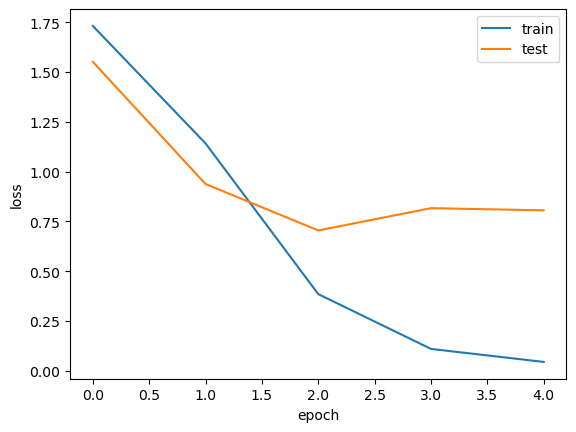

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show();

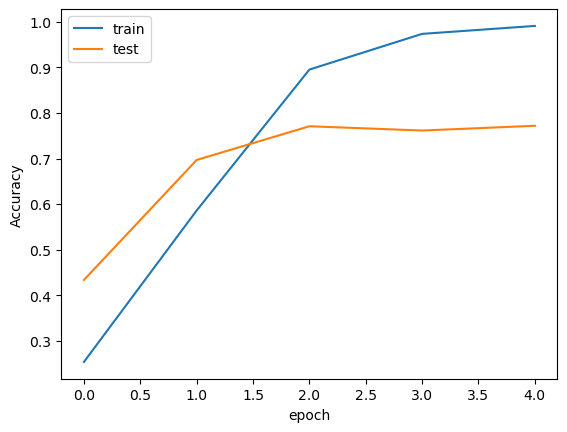

In [26]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show();

In [27]:
new_summary = ["Colbert Burns 'Complete Moron' Matt Gaetz With A Reminder Of His Legal Problems.'The Late Show' host had a scathing retort to the embattled Florida lawmaker's tweet.  "]

In [29]:
seq = tokenizer.texts_to_sequences(new_summary)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = lstm_model.predict(padded)


In [30]:
print(pred, category_list[np.argmax(pred)])

[[0.16173741 0.22526866 0.56891024 0.01391509 0.0294124  0.00075609]] TRAVEL


# Visualize tensorflow graph

In [33]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5908), started 0:03:40 ago. (Use '!kill 5908' to kill it.)